In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn 

from tqdm import tqdm

2023-05-17 08:29:37.980789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 08:29:38.692316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-17 08:29:38.692395: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-17 08:29:41.231949: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
data_imgs = np.load('../Kanji-recognizer/data/kkanj-imgs.npz')
data_labels = np.load('../Kanji-recognizer/data/kkanji-labels.npz')

imgs = data_imgs['arr_0']
labels = data_labels['arr_0']

def kanji(kaniUnicode):
    return chr(int(kaniUnicode[2:], 16))

X = imgs[14000:44000]
Z = labels[14000:44000]


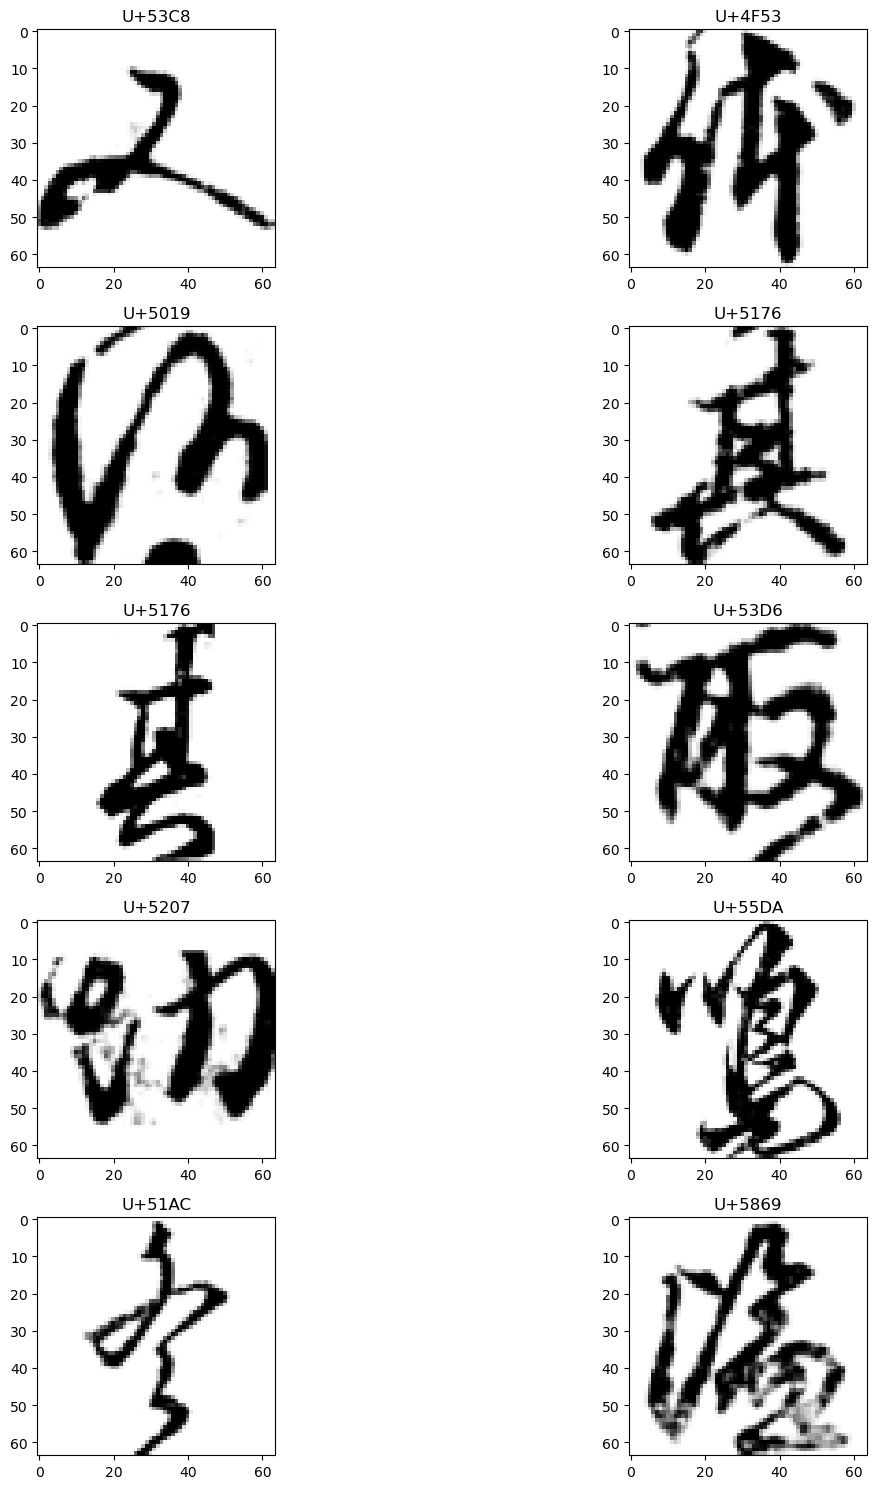

In [3]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l], cmap='Greys')
        ax[i,j].set_title(Z[l])
        
        
plt.tight_layout()

In [4]:
len(np.unique(Z))

524

In [5]:
le=LabelEncoder()


Y=le.fit_transform(Z)


Y=to_categorical(Y,len(np.unique(Z)))


X=np.array(X)


X=X/255


In [6]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=42)
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [7]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size= (3,3), padding= 'Same', activation='relu', input_shape = (64,64, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size= (3,3), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 96, kernel_size= (1,1), padding= 'Same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(len(np.unique(Z)), activation="softmax"))

2023-05-17 08:29:55.029879: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-17 08:29:55.032473: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-17 08:29:55.032592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (108bb72cdfce): /proc/driver/nvidia/version does not exist
2023-05-17 08:29:55.034865: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
batch_size=200
epochs=3

from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.1)

In [9]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False,
    vertical_flip=False
)

#datagen.fit(x_train.reshape(10500, 64, 64, 1))

In [10]:
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        6240      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 96)         0

In [12]:
History = model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test), verbose=1, steps_per_epoch=x_train.shape[0] // batch_size)

2023-05-17 08:29:56.317620: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 368640000 exceeds 10% of free system memory.


Epoch 1/3
112/112 [==============================] - 54s 472ms/step - loss: 3.6113 - accuracy: 0.3433 - val_loss: 2.0616 - val_accuracy: 0.5916
Epoch 2/3
112/112 [==============================] - 52s 463ms/step - loss: 1.3846 - accuracy: 0.7134 - val_loss: 1.1305 - val_accuracy: 0.7725
Epoch 3/3
112/112 [==============================] - 50s 449ms/step - loss: 0.7329 - accuracy: 0.8239 - val_loss: 0.8976 - val_accuracy: 0.8105


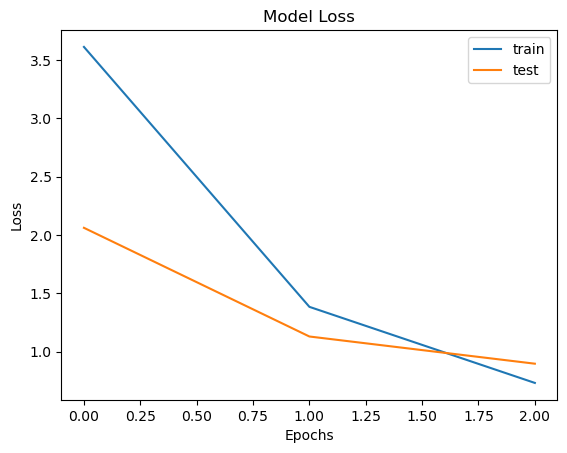

In [13]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [14]:
accuracy_history = []
accuracy_history_img = []

1/1 [==============================] - 0s 117ms/step
Predicted class: 5
Predicted class probability: 99.96849298477173 %


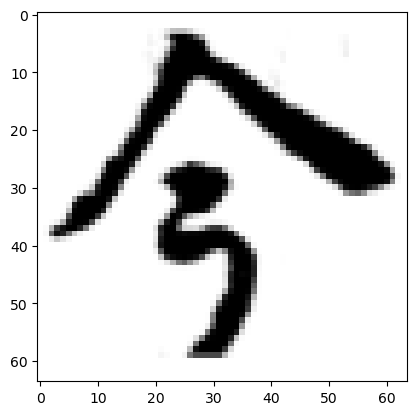

In [15]:
from matplotlib import pyplot


results = model.evaluate(x_test, y_test)
image_number = 2172
new_image = tf.expand_dims(x_test[image_number], 0)
predictions = model.predict(new_image)
predicted_class_index = predictions.argmax(axis=-1)[0]
predicted_class_probability = predictions[0][predicted_class_index]
print('Predicted class:', predicted_class_index)
print('Predicted class probability:', predicted_class_probability*100, "%")

accuracy_history.append(predicted_class_probability*100)
accuracy_history_img.append(image_number)

pyplot.imshow(x_test[image_number], cmap='Greys')
#print(kanji(y_test[image_number]))


In [16]:
import webscraping

class_prediction = 77
print("Code: ", np.unique(Z)[class_prediction])
print(kanji(np.unique(Z)[class_prediction]))
webscraping.get_meaning(kanji(np.unique(Z)[class_prediction]))

Code:  U+4FF3
俳

haiku, 
actor



In [20]:
from matplotlib import pyplot
import random

accuracy_history = []
accuracy_history_img = []
predicted_class_index_list = [] 

for _ in range(400):
    image_number = random.randint(0, len(x_test) - 1)
    new_image = tf.expand_dims(x_test[image_number], 0)
    predictions = model.predict(new_image)
    predicted_class_index = predictions.argmax(axis=-1)[0]
    predicted_class_probability = predictions[0][predicted_class_index]
    print('Predicted class:', predicted_class_index)
    print('Predicted class probability:', predicted_class_probability * 100, "%")

    accuracy_history.append(predicted_class_probability * 100)
    accuracy_history_img.append(image_number)
    predicted_class_index_list.append(predicted_class_index)

    # pyplot.imshow(x_test[image_number], cmap='Greys')
    # pyplot.show()


1/1 [==============================] - 0s 39ms/step
Predicted class: 134
Predicted class probability: 17.574357986450195 %
1/1 [==============================] - 0s 33ms/step
Predicted class: 435
Predicted class probability: 99.65734481811523 %
1/1 [==============================] - 0s 34ms/step
Predicted class: 187
Predicted class probability: 99.96951818466187 %
1/1 [==============================] - 0s 41ms/step
Predicted class: 319
Predicted class probability: 99.97344613075256 %
1/1 [==============================] - 0s 39ms/step
Predicted class: 337
Predicted class probability: 94.90262269973755 %
1/1 [==============================] - 0s 51ms/step
Predicted class: 312
Predicted class probability: 98.9582896232605 %
1/1 [==============================] - 0s 80ms/step
Predicted class: 174
Predicted class probability: 49.242451786994934 %
1/1 [==============================] - 0s 42ms/step
Predicted class: 435
Predicted class probability: 47.79863655567169 %
1/1 [==================

[17.574357986450195, 99.65734481811523, 99.96951818466187, 99.97344613075256, 94.90262269973755, 98.9582896232605, 49.242451786994934, 47.79863655567169, 45.630449056625366, 74.55851435661316, 95.97276449203491, 82.4610710144043, 99.41546320915222, 99.61806535720825, 19.540375471115112, 43.96920204162598, 93.28292608261108, 35.11840105056763, 40.46536982059479, 49.456414580345154, 39.029186964035034, 99.86496567726135, 95.00622749328613, 42.44337975978851, 51.566797494888306, 86.86118721961975, 31.347033381462097, 94.9911117553711, 97.98336625099182, 99.99452829360962, 40.915647149086, 99.98511075973511, 74.12858605384827, 99.62857961654663, 99.98189806938171, 23.09078276157379, 51.15733742713928, 90.8398449420929, 99.80170726776123, 94.39696669578552, 99.99967813491821, 99.98214840888977, 94.30652856826782, 55.35802245140076, 99.99960660934448, 99.96032118797302, 99.94344115257263, 40.85319638252258, 99.98425245285034, 99.35793876647949, 75.17534494400024, 99.63539838790894, 99.977535

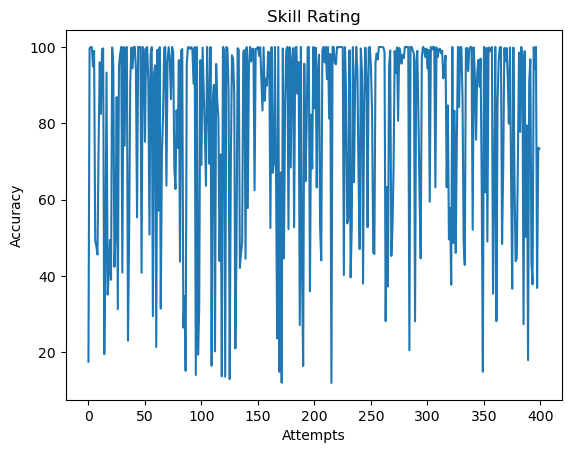

In [21]:

print(accuracy_history)
plt.plot(accuracy_history)
plt.title('Skill Rating')
plt.ylabel('Accuracy')
plt.xlabel('Attempts')
plt.show()

In [22]:
result = []
for a, b, c in zip(accuracy_history_img, accuracy_history, predicted_class_index_list):
    result.append((a, b, c))

for r in range(len(result)):
    image_number = result[r][0]
    accuracy = result[r][1]
    predicted_class_index = result[r][2]
    
    print("Element:", r+1)
    print("Image number:", image_number)
    print("Accuracy:", accuracy, "%")
    print("Predicted class index:", predicted_class_index)
    print()

average = sum(accuracy_history) / len(accuracy_history)
print("Average:", average, "%")

Element: 1
Image number: 5201
Accuracy: 17.574357986450195 %
Predicted class index: 134

Element: 2
Image number: 1401
Accuracy: 99.65734481811523 %
Predicted class index: 435

Element: 3
Image number: 4375
Accuracy: 99.96951818466187 %
Predicted class index: 187

Element: 4
Image number: 5973
Accuracy: 99.97344613075256 %
Predicted class index: 319

Element: 5
Image number: 2005
Accuracy: 94.90262269973755 %
Predicted class index: 337

Element: 6
Image number: 1338
Accuracy: 98.9582896232605 %
Predicted class index: 312

Element: 7
Image number: 3786
Accuracy: 49.242451786994934 %
Predicted class index: 174

Element: 8
Image number: 3108
Accuracy: 47.79863655567169 %
Predicted class index: 435

Element: 9
Image number: 2211
Accuracy: 45.630449056625366 %
Predicted class index: 494

Element: 10
Image number: 5242
Accuracy: 74.55851435661316 %
Predicted class index: 334

Element: 11
Image number: 5637
Accuracy: 95.97276449203491 %
Predicted class index: 187

Element: 12
Image number: 45